In [1]:
# load packages
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from torch.utils.data import DataLoader

In [2]:
# file path
DATASET_PATH ="/content/drive/MyDrive/452 final project/lfw-deepfunneled"
ATTRIBUTES_PATH = "/content/drive/MyDrive/452 final project/lfw_attributes.txt"
#DATASET_PATH ="/content/drive/MyDrive/Colab Notebooks/CPSC452/452 final project/lfw-deepfunneled"
#ATTRIBUTES_PATH = "/content/drive/MyDrive/Colab Notebooks/CPSC452/452 final project/lfw_attributes.txt"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read in data
dataset = [{"person": path.split("/")[-2], "path": path}
           for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg"))]

dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 100)
dataset.head(10)

,person,path
0,Bill_Readdy,/content/drive/MyDrive/452 final project/lfw-d...
1,Jenny_Romero,/content/drive/MyDrive/452 final project/lfw-d...
2,Melana_Scantlin,/content/drive/MyDrive/452 final project/lfw-d...
3,Steve_Karsay,/content/drive/MyDrive/452 final project/lfw-d...
4,Alejandro_Toledo,/content/drive/MyDrive/452 final project/lfw-d...
5,Alejandro_Toledo,/content/drive/MyDrive/452 final project/lfw-d...
6,Alejandro_Toledo,/content/drive/MyDrive/452 final project/lfw-d...
7,Alejandro_Toledo,/content/drive/MyDrive/452 final project/lfw-d...
8,Alejandro_Toledo,/content/drive/MyDrive/452 final project/lfw-d...
9,Alejandro_Toledo,/content/drive/MyDrive/452 final project/lfw-d...


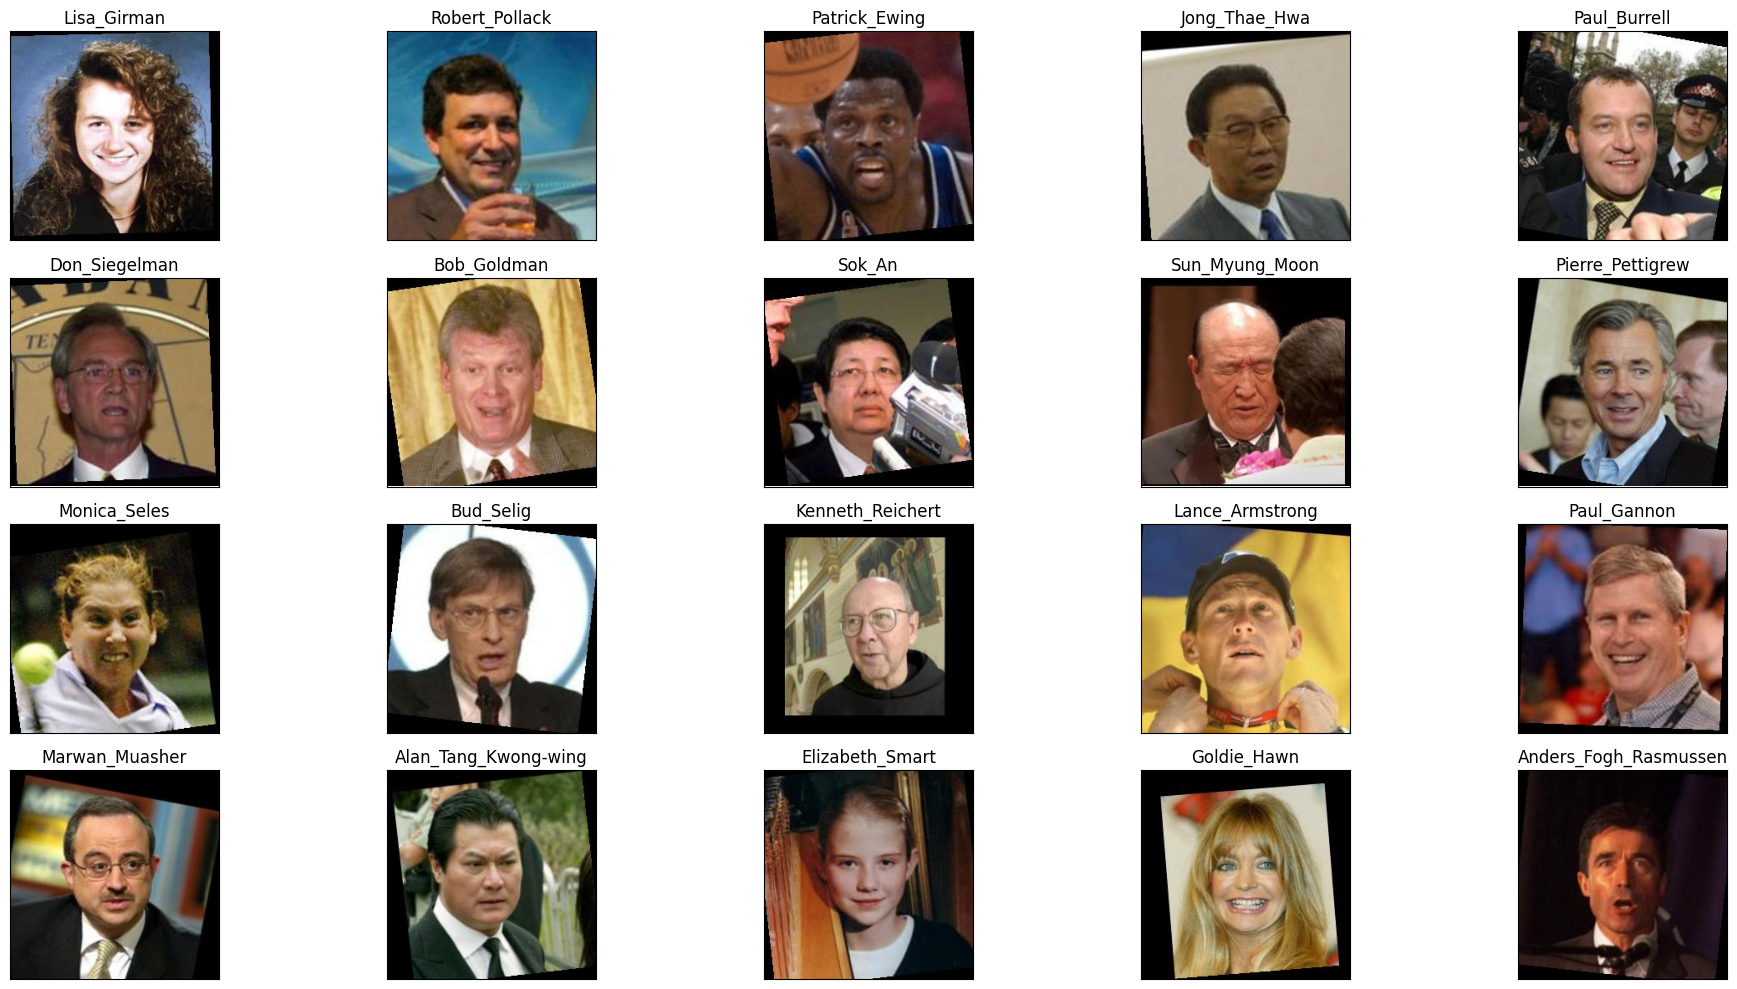

In [5]:
# sample image display
sampled_id = []

plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
    sampled_id.append(idx)
plt.tight_layout()
plt.show()

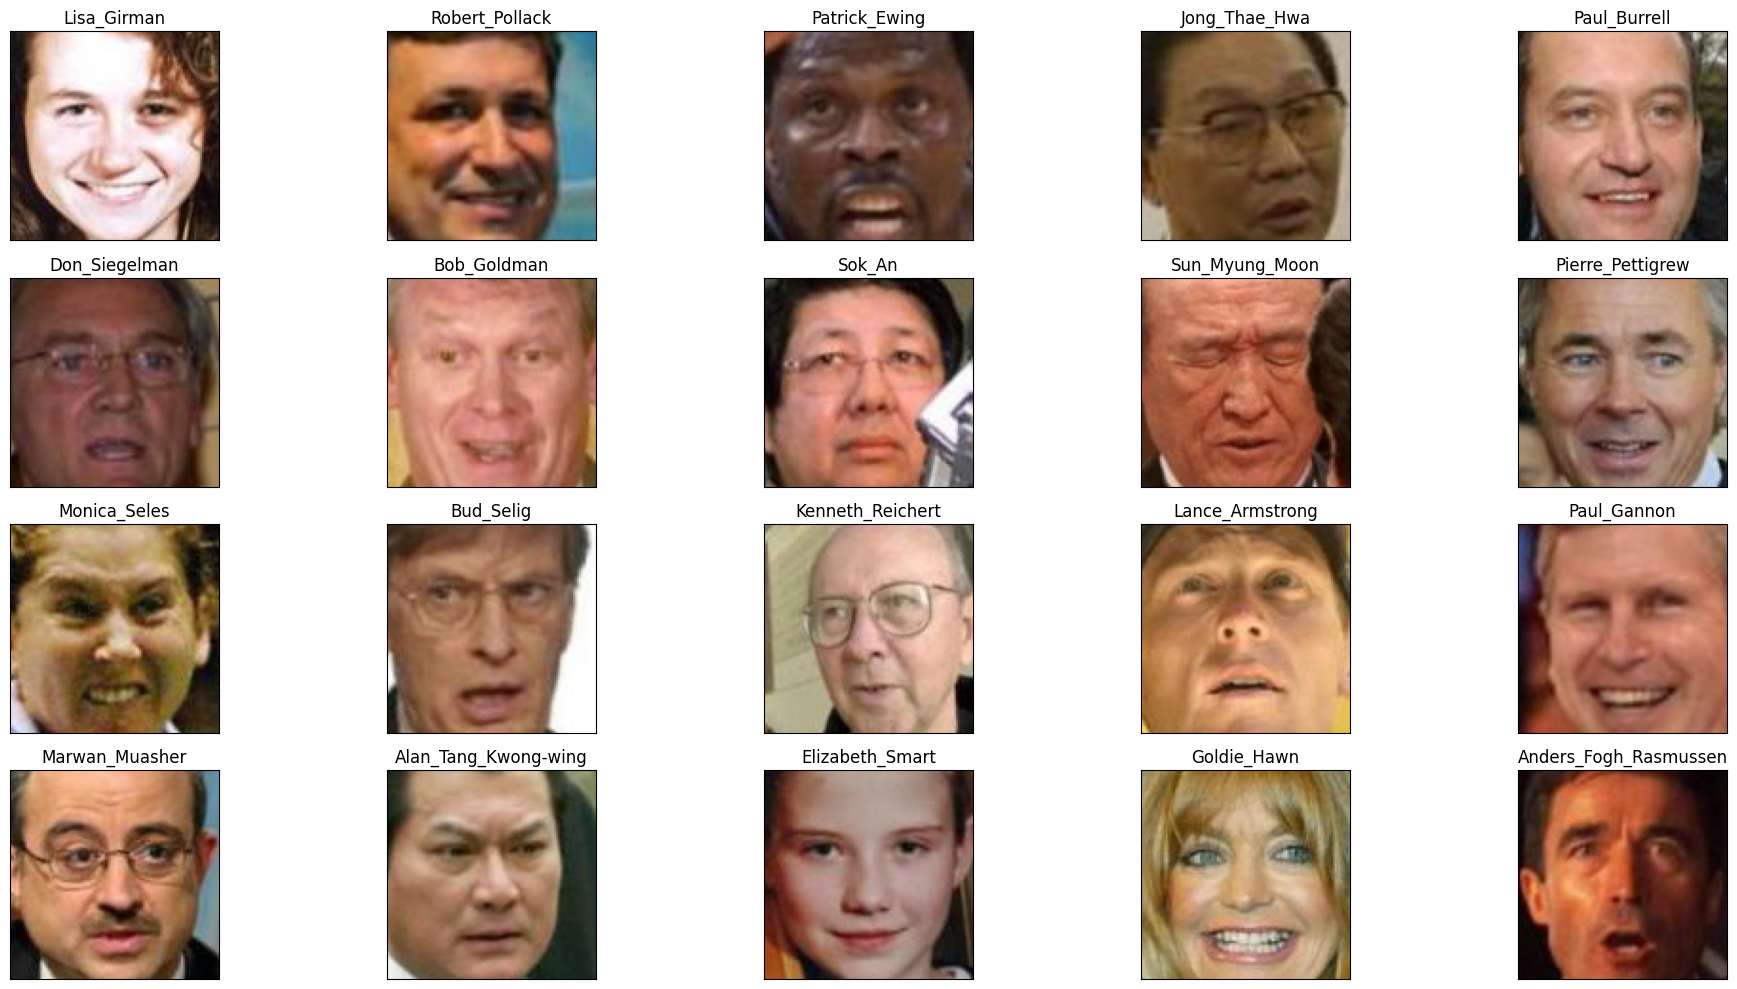

In [6]:
# show the image with background removed
dx=70
dy=70

plt.figure(figsize=(20,10))
for i in range(20):
    idx = sampled_id[i]
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img[dy:-dy,dx:-dx])
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [7]:
d=pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
d['Smiling'].describe()

count    13143.000000
mean         0.148661
std          1.163603
min         -2.953572
25%         -0.791946
50%          0.312447
75%          1.084248
max          2.839384
Name: Smiling, dtype: float64

In [8]:
def fetch_dataset(dx=70, dy=70, dimx=45, dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                if photo_id[-1]=='(1)':
                  continue
                # print(photo_id)
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))
    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [9]:
# images are stored in data variable, attributes of the image are stored in the attrs variable
data, attrs = fetch_dataset()
data = np.array(data / 255, dtype='float32')

In [10]:
# extract smile feature
smile_ids = [[1, 0] if item == 1 else [0, 1] for item in 1*(attrs['Smiling']>=0)] 

In [11]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(3*3*128, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,3*3*128)
        x = self.fc1(x)
        return x

def train(args, model, device, train_loader, optimizer, epoch):

    model.train()
    train_loss = 0


    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()
        output = model(data)
        loss_fn = nn.CrossEntropyLoss()
        loss=loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')

    train_loss /= len(train_loader)
    print(f"\rTrain Epoch: {epoch: 3} \t| Train set: Average loss: {train_loss:.4f}{' '*50}")

def test(args, model, device, test_loader, epoch):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output)
            loss_fn = nn.CrossEntropyLoss()
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def main():

    parser = argparse.ArgumentParser(description='Face')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=64, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='number of epochs to train (default: 5)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    train_data, test_data, train_labels, test_labels = train_test_split(torch.tensor(data), torch.tensor(smile_ids), test_size=0.2, random_state=42)
    train_data=train_data.view(-1, 3, 45, 45)
    test_data=test_data.view(-1, 3, 45, 45)
    train_labels=train_labels.to(dtype=torch.float32)
    print(sum(train_labels))
    test_labels=test_labels.to(dtype=torch.float32)
    print(sum(test_labels))
    train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
    test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs
    )

    model = CNN().to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader, epoch)

if __name__ == '__main__':
    main()


tensor([4339., 6175.])
tensor([1093., 1536.])
Train Epoch:   1 	| Train set: Average loss: 0.5834                                                  
Test set: Average loss: 0.0080, Accuracy: 2001/2629 (76%)

Train Epoch:   2 	| Train set: Average loss: 0.4267                                                  
Test set: Average loss: 0.0073, Accuracy: 2058/2629 (78%)

Train Epoch:   3 	| Train set: Average loss: 0.3760                                                  
Test set: Average loss: 0.0062, Accuracy: 2153/2629 (82%)

Train Epoch:   4 	| Train set: Average loss: 0.3381                                                  
Test set: Average loss: 0.0054, Accuracy: 2256/2629 (86%)

Train Epoch:   5 	| Train set: Average loss: 0.3149                                                  
Test set: Average loss: 0.0052, Accuracy: 2256/2629 (86%)

Train Epoch:   6 	| Train set: Average loss: 0.3092                                                  
Test set: Average loss: 0.0049, Accuracy: 2280/